In [4]:
from calc_trust import *
from generate_attestations import *

num_wallets = 25
wallet_addresses = generate_wallet_addresses(num_wallets)
print_trusted_wallet_addresses(wallet_addresses)

attestations = []
attestations = generate_attestations(1000,wallet_addresses=wallet_addresses, attestations=attestations)
updated_attestations, wallet_addresses = calculate_trust(attestations,wallet_addresses)
# for attestation in updated_attestations:   
#     print(attestation.Tc)

Trusted Wallet Addresses:
address6
address7
Converged in 4 rounds!


In [7]:
import networkx as nx
import matplotlib.pyplot as plt
from pyvis.network import Network

def create_network_graph(wallet_addresses, attestations, selected_claim, top_n=50):
    G = nx.DiGraph()  # Directed graph, as attestations are directed from attester to recipient
    
    # Filter attestations based on the selected claim
    filtered_attestations = [attestation for attestation in attestations if selected_claim in attestation.data.keys()]
    
    # Sort attestations based on trust scores and select the top n
    #sorted_attestations = sorted(filtered_attestations, key=lambda x: x.Tc.get(selected_claim, 0), reverse=True)
    #top_attestations = sorted_attestations[:top_n]
    top_attestations = filtered_attestations[:top_n]
    # Add nodes for wallet addresses
    for address, properties in wallet_addresses.items():
        if properties['role'] == 'honest':
            color = 'blue' 
        elif properties['role'] == 'trusted':
            color = 'purple' 
        else:
            color = 'red'
        
        # Find associated attestations for this address and selected claim
        associated_attestations = [attestation for attestation in top_attestations if attestation.attester == address or attestation.recipient == address]
        
        if not associated_attestations:  # Skip if no associated attestations for this address and claim
            continue
        
        # Assuming each address has at least one associated attestation
        associated_attestation = associated_attestations[0]
        #G.add_node(address, color=color, role=properties['role'], label=f"{address}\n{associated_attestation.Ti_attester if associated_attestation.attester == address else associated_attestation.Ti_recipient}\n{properties['is_human']}")
        G.add_node(address, color=color, role=properties['role'], label=f"{address}\n Calculated trust: {properties['calculated_trust']['is_safe']}\n Actually safe: {properties['is_safe']}")
    # Add nodes for attestations and edges from attester to attestation and from attestation to recipient
    for attestation in top_attestations:
        G.add_node(attestation.uid, color='green', role='attestation', label=f"{attestation.uid}\n{attestation.Tc}", size=10)  # Reduced size for attestation nodes
        G.add_edge(attestation.attester, attestation.uid, role='attester_to_attestation', alpha=0.5)  # Added transparency
        if attestation.recipient:  # If there is a recipient, add edge from attestation to recipient
            G.add_edge(attestation.uid, attestation.recipient, role='attestation_to_recipient', alpha=0.5)  # Added transparency
    
    return G

def draw_network_graph(G):
    pos = nx.spring_layout(G)
    colors = [node[1]['color'] for node in G.nodes(data=True)]
    labels = {node: data['label'] for node, data in G.nodes(data=True)}
    
    nx.draw(G, pos, node_color=colors, with_labels=False, node_size= 1)
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=8, verticalalignment='center_baseline')
    plt.show()


def save_network_graph(G,filename):
    nt = Network(notebook=False)
    
    # Add nodes and edges to the pyvis network
    for node, data in G.nodes(data=True):
        nt.add_node(node, title=data['label'], color=data['color'])
    
    for source, target, data in G.edges(data=True):
        nt.add_edge(source, target)
    
    # Display the interactive graph
    nt.save_graph(filename)




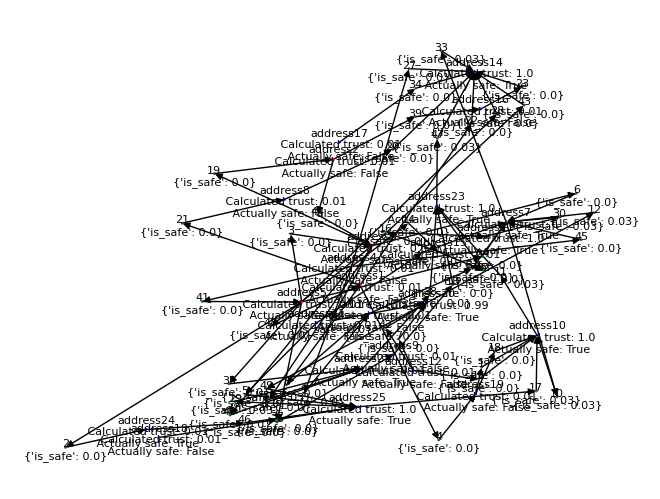

In [8]:

# Assuming wallet_addresses and attestations are already defined
selected_claim = "is_safe"  # Or any other claim you want to visualize
G = create_network_graph(wallet_addresses, attestations, selected_claim)
draw_network_graph(G)
save_network_graph(G, "is_safe_graph.html")
